## Sentimental Analysis on a Review Dataset using Embedding

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,random_split,TensorDataset
from tqdm.notebook import tqdm

In [4]:
# Reading the dataset
df = pd.read_csv('https://raw.githubusercontent.com/soumyajit4419/Deep_Learning_Projects/master/NLP_With_PyTorch/Dataset/feedback%20dataset.csv')
df.head()

,text,sentiment
0,Display is excellent and camera is as good as ...,1
1,Battery life is also great!,1
2,Protects the phone on all sides.,1
3,"Clear Skype Calls, Long Battery Life, Long Range.",1
4,Great Hands Free Device.,1


In [5]:
df.shape

(5200, 2)

In [6]:
df.isnull().sum()

text         0
sentiment    0
dtype: int64

In [7]:
# Cleaning the text
wordnet  = WordNetLemmatizer()
def clean_text(text):
  text = re.sub('[^a-zA-Z]',' ',text)
  text = text.lower()
  text = text.split(' ')
  text = [wordnet.lemmatize(word) for word in text if word not in stopwords.words('english')]
  text = ' '.join(text)
  return text

In [8]:
df['cleaned_text'] = df['text'].apply(clean_text)

In [9]:
# Creating Tokens
vectorizer = CountVectorizer()
vectorizer.fit(df['cleaned_text'])

# Creating words to id
token2idx = vectorizer.vocabulary_
token2idx['UNK'] = max(token2idx.values())+1

# Creating a dictionary of id to words
idx2token = {idx:token for token,idx in token2idx.items()}

In [10]:
# Total number of words
vocab_size = len(token2idx)
vocab_size

4910

In [11]:
# Encode the sentence into numbers and padding 
def encode(text,max_len=30):
  text = text.strip()
  text = text.split(' ')
  encoded = np.zeros(max_len,dtype=int)
  enc = [token2idx.get(word,token2idx['UNK']) for word in text] 
  length = min(max_len,len(enc))
  encoded[:length] = enc[:length]
  return encoded

In [12]:
df['encoded'] = df['cleaned_text'].apply(encode)

In [13]:
df.head()

,text,sentiment,cleaned_text,encoded
0,Display is excellent and camera is as good as ...,1,display excellent camera good year,"[1207, 1490, 578, 1873, 4888, 0, 0, 0, 0, 0, 0..."
1,Battery life is also great!,1,battery life also great,"[345, 2498, 128, 1903, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,Protects the phone on all sides.,1,protects phone side,"[3356, 3168, 3900, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"Clear Skype Calls, Long Battery Life, Long Range.",1,clear skype call long battery life long range,"[742, 3940, 571, 4909, 2548, 345, 2498, 4909, ..."
4,Great Hands Free Device.,1,great hand free device,"[1903, 1955, 1751, 1141, 0, 0, 0, 0, 0, 0, 0, ..."


In [14]:
# Creating tensor of input and target
inputs = torch.tensor(df['encoded'],dtype=torch.long)
target = torch.tensor(df[['sentiment']].values,dtype=torch.float)

In [15]:
# Dataset 
dataset = TensorDataset(inputs,target)

# Creating training and validation dataset
val_size = int(len(dataset) * 0.2)
train_size = len(dataset) - val_size
train_ds,val_ds = random_split(dataset,[train_size,val_size])

# Dataloader
train_loader = DataLoader(train_ds,batch_size=64,shuffle=True,num_workers=3,pin_memory=True)
val_loader = DataLoader(val_ds,batch_size=64,shuffle=True,num_workers=3,pin_memory=True)

In [16]:
# Using GPU device if available
def get_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

device = get_device()
device

device(type='cuda')

In [17]:
# Defining  a model
class Sentimental_Analysis(nn.Module):

  def __init__(self):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size,100)
    self.lstm = nn.LSTM(100,128,num_layers=1,batch_first=True)
    self.linear = nn.Linear(128,1)

  def forward(self,xb):
    # Passing a batch of data to the embedding layer
    out = self.embedding(xb)
    # Passing the outut to the lstm layer
    out,(ht,ct) = self.lstm(out)
    # Getting the output from the final layer
    out = ht[-1]
    out = self.linear(out)
    out = F.sigmoid(out)
    return out

In [18]:
# Instatiating the the model
model = Sentimental_Analysis()

In [19]:
model

Sentimental_Analysis(
  (embedding): Embedding(4910, 100)
  (lstm): LSTM(100, 128, batch_first=True)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)

In [20]:
# Moving the model to gpu
model = model.to(device)

In [21]:
# Function to get accuracy
def accuracy(pred,target):
  rounded_preds = torch.round(pred)
  correct = (rounded_preds == target).float() 
  acc = correct.sum() / len(correct)
  return acc

# Checking the validation loss and validation accuracy
def evaluate(model):
  model.eval()
  losses = []
  accuracies = []
  for input,target in val_loader:
    input = input.to(device)
    target = target.to(device)
    out = model(input)
    loss = F.binary_cross_entropy(out,target)
    acc = accuracy(out,target)
    accuracies.append(acc)
    losses.append(loss)
  return torch.stack(losses).mean().item(), torch.stack(accuracies).mean().item()

In [22]:
# Training the model for some number of epochs
def fit(num_epochs):
  train_losses = []
  val_losses = []
  val_accs = []
  optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
  for epoch in range(num_epochs):
    model.train()
    losses = []
    # Loading the batches of data
    for input,target in tqdm(train_loader):
      # Moving the data to the device
      input = input.to(device)
      target = target.to(device)
      
      input = input.long()
      target = target.float()
      
      # Getting the outputs of the model
      out = model(input)
      # Calulating the loss
      loss = F.binary_cross_entropy(out,target)
      # Computing the gradients
      loss.backward()
      # Gradient Clipping
      nn.utils.clip_grad_norm_(model.parameters(),5)
      # Updating the weights and bias
      optimizer.step()
      optimizer.zero_grad()
      losses.append(loss)
     
    train_loss = torch.stack(losses).mean().item()
    val_loss,val_acc = evaluate(model)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
  
    print("Epoch: {}, train_loss: {}, val_loss: {}, val_acc: {}".format(epoch+1,train_loss,val_loss,val_acc))
  return train_losses,val_losses,val_accs

In [23]:
# Evaluating the model before training
evaluate(model)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


(0.6927734613418579, 0.5119485259056091)

In [24]:
# Training the model
history = fit(10)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



Epoch: 1, train_loss: 0.6958994269371033, val_loss: 0.6931378841400146, val_acc: 0.5064338445663452



Epoch: 2, train_loss: 0.6936076283454895, val_loss: 0.6956447958946228, val_acc: 0.4908088147640228



Epoch: 3, train_loss: 0.6928887367248535, val_loss: 0.6931183338165283, val_acc: 0.49632352590560913



Epoch: 4, train_loss: 0.6899548172950745, val_loss: 0.6719132661819458, val_acc: 0.6488970518112183



Epoch: 5, train_loss: 0.5979083776473999, val_loss: 0.5488466620445251, val_acc: 0.7279411554336548



Epoch: 6, train_loss: 0.4645031988620758, val_loss: 0.49523499608039856, val_acc: 0.7720588445663452



Epoch: 7, train_loss: 0.36732786893844604, val_loss: 0.49348315596580505, val_acc: 0.7748161554336548



Epoch: 8, train_loss: 0.29017356038093567, val_loss: 0.49616846442222595, val_acc: 0.7895220518112183



Epoch: 9, train_loss: 0.23738589882850647, val_loss: 0.5365273356437683, val_acc: 0.7959558963775635



Epoch: 10, train_loss: 0.19052819907665253, val_loss: 0.5726078152656555, val_acc: 0.8060661554336548


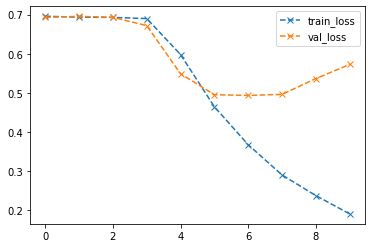

In [25]:
# Plotting the losses 
train_losses,val_losses,val_acc = history 
plt.plot(train_losses,label='train_loss',linestyle='--', marker='x')
plt.plot(val_losses,label='val_loss',linestyle='--',marker='x')
plt.legend()
plt.show()

In [26]:
# evaluating the model after training
evaluate(model)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


(0.5735471248626709, 0.8060661554336548)